In [25]:
# This makes the jupyter notebook wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [26]:
import pytz
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [27]:
taxon = 'Margalefidinium'
df = pd.read_csv(f'../data/{taxon}.csv', index_col='pid',
    parse_dates=['sample_time','bin_added','taxon_added'])
#df.tail()

In [28]:
def rust_simulate(df, threshold, timer, timestep=30, verbose=True):
    v = verbose
    # Calculating pump-off cycles
    pump_timer = None
    pump_times = []
    timestep = dt.timedelta(minutes=timestep)
    start_time = min(df.taxon_added.dt.round('30min'))
    end_time = max(df.taxon_added)
    cron_time = start_time+dt.timedelta(minutes=6)

    while cron_time<end_time:
        cron_time = cron_time+timestep
        if v: print(cron_time)
        latest_valid_row = df[df.taxon_added<=cron_time].iloc[-1]
        bin_id = latest_valid_row.name
        taxon_perL = latest_valid_row['taxon_perL']
        sample_time = latest_valid_row['sample_time']


        # 3) check for any triggering behaviors
        if v: print(f'Checking Counts Against Threshold ({threshold} perL)')
        ago = cron_time-sample_time
        if v: print(f'  Latest Counts: {round(taxon_perL)} perL (sample_time: {str(ago).replace("0 days ","")} ago, from {bin_id})')

        if taxon_perL > threshold:
            if pump_timer is None:
                if v: print('Counts Above Threshold: Setting pump timer + Turning Pump OFF and Aerator ON')
                #if args.powerstrip: set_pumpOff_aeratorOn(pump_args,aerator_args)
                pump_times.append([(sample_time,taxon_perL),cron_time])
            elif pump_timer==sample_time:
                if v: print('Counts Still Above Threshold: No New Classification Data')
            else:
                if v: print('Counts Still Above Threshold: Re-Setting pump timer')
            pump_timer = sample_time

        elif pump_timer and sample_time - pump_timer > dt.timedelta(hours=timer):
            if v: print('  Counts Below Threshold and Pump Timer has run out: Turning Pump back ON and Aerator OFF')
            #if args.powerstrip: set_pumpOn_aeratorOff(pump_args,aerator_args)
            pump_timer = None
            pump_times[-1].append(cron_time)

        elif pump_timer:
            remaining = (cron_time-pump_timer)-dt.timedelta(hours=timer)
            if v: print(f'  Counts Below Threshold, but {str(remaining).replace("0 days ","")} remains on Pump Timer')

        else:
            if v: print('  Counts Below Threshold: all is well')
        if v: print('---------------------------------------------------------')
    return pump_times

def do_plot(df, pump_times, threshold, show_bins_added=True):

    pump_times = filter(lambda x: len(x)==3, pump_times)

    # create plot object
    fig, ax = plt.subplots(figsize=(10,4))
    
    # plot a vertical span for each pump off-on cycle
    for orig, pump_off_time, pump_on_time in pump_times:
        ax.axvspan(xmin=pump_off_time, xmax=pump_on_time, alpha=0.25, color='orange')
        #ax.hlines(y=orig[1], xmin=orig[0], xmax=pump_off_time, color='orange', linestyles=':')
        ax.plot([orig[0], pump_off_time], [orig[1],df['taxon_perL'].max()], color='orange', linestyle=':')

    if show_bins_added:
        for idx,row in df.iterrows():
            ax.vlines(x=row['bin_added'], ymin=0, ymax=df['taxon_perL'].max(),
                      linestyles=':',linewidth=0.5, color='black')

    # plot cells per liter timeseries
    ax.plot(df['sample_time'],df['taxon_perL'])
    
    # plot horizontal threshold line
    ax.hlines(y=threshold,xmin=df.sample_time[0],xmax=df.sample_time[-1], color='black', linewidth=1)
    
    # annotations
    plt.ylabel("Cells per Liter")
    plt.ylabel("Sample Time")
    plt.title(f'{taxon} 2020')
    plt.xticks(rotation=90)
    
    plt.show()

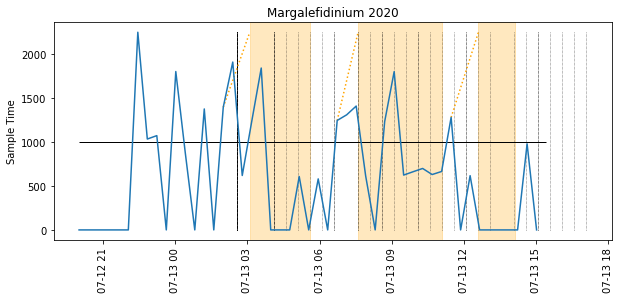

In [29]:
TIMESTEP=30
THRESHOLD = 1000   # counts per liter
TIMER = 1  # hours

pump_times = rust_simulate(df, THRESHOLD, TIMER, timestep=TIMESTEP, verbose=False)
do_plot(df, pump_times, THRESHOLD )